## Уровень 1 — Подключения

Выполняется в final_homework.
 Подключиться к серверу Trino из Jupyter Notebook (настроить Python-
клиент, параметры хоста/порта/каталога).
 Проверить доступность каталога PostgreSQL в Trino:
 вывести список схем;
 вывести список таблиц хотя бы в одной схеме (например, SHOW
SCHEMAS, SHOW TABLES).
 Аналогично проверить доступность каталога MySQL: список схем и таблиц.

In [70]:
!pip install trino
!pip install pandas
!pip install matplotlib

In [71]:
from trino.dbapi import connect

conn = connect(
    host='localhost',
    port=8080,
    user='trino',
    catalog='iceberg',
    schema='default',
    http_scheme='http'
)

cursor = conn.cursor()
print("Connected")


Connected


In [72]:
cursor.execute("SHOW SCHEMAS FROM postgresql")
schemas_pg = cursor.fetchall()

print("Schemas from postgresql:")
for schema in schemas_pg:
    print(schema[0])

cursor.execute("SHOW TABLES FROM postgresql.public")
tables_pg = cursor.fetchall()

print("\nTables from postgresql.public:")
for table in tables_pg:
    print(table[0])


Schemas from postgresql:
information_schema
pg_catalog
public

Tables from postgresql.public:
city
country
country_flag
country_language


In [73]:
cursor.execute("SHOW SCHEMAS FROM mysql")
schemas_mysql = cursor.fetchall()

print("Schemas from mysql:")
for schema in schemas_mysql:
    print(schema[0])

cursor.execute("SHOW TABLES FROM mysql.sakila")
tables_mysql = cursor.fetchall()

print("\nTables from mysql.sakila:")
for table in tables_mysql:
    print(table[0])


Schemas from mysql:
information_schema
performance_schema
sakila

Tables from mysql.sakila:
actor
actor_info
address
category
city
country
customer
customer_list
film
film_actor
film_category
film_list
film_text
inventory
language
nicer_but_slower_film_list
payment
rental
sales_by_film_category
sales_by_store
staff
staff_list
store


## Уровень 2 — Агрегация данных

 Выбрать одну или несколько таблиц в PostgreSQL и/или MySQL,
содержащие числовые или датовые поля (например, заказы, транзакции,
метрики).
 Сформировать и выполнить минимум два агрегирующих SQL-запроса
через Trino, например:
 группировки по дате, клиенту, категории;
 подсчет количества записей, суммирование, средние значения;
 top-N по какому-либо показателю.
 Загрузить результаты этих агрегирующих запросов в pandas DataFrame.
 На основе полученных DataFrame сформировать финальный
агрегированный DataFrame, который будет использоваться и для
визуализации, и для сохранения в Iceberg.

### Для postgres
1. Population by cities and countris
2. Continent analysis

In [74]:
import pandas as pd

query1 = """
SELECT 
    country.name as country_name,
    country.continent,
    COUNT(city.id) as city_count,
    SUM(city.population) as total_city_population,
    country.population as country_population
FROM postgresql.public.country
JOIN postgresql.public.city ON country.code = city.country_code
GROUP BY country.name, country.continent, country.population
HAVING COUNT(city.id) > 5
ORDER BY city_count DESC
LIMIT 30
"""

cursor.execute(query1)
results = cursor.fetchall()
cols = [d[0] for d in cursor.description]

df_countries = pd.DataFrame(results, columns=cols)
print(f"Countries count: {len(df_countries)}")
print(df_countries.head())

print("Stats:")
print(df_countries.describe())

Countries count: 30
    country_name      continent  city_count  total_city_population  \
0          China           Asia         363              175953614   
1          India           Asia         341              123298526   
2  United States  North America         274               78625774   
3         Brazil  South America         250               85876862   
4          Japan           Asia         248               77965107   

   country_population  
0          1277558000  
1          1013662000  
2           278357000  
3           170115000  
4           126714000  
Stats:
       city_count  total_city_population  country_population
count   30.000000           3.000000e+01        3.000000e+01
mean   105.966667           3.779899e+07        1.513369e+08
std     95.918242           3.821851e+07        2.791811e+08
min     29.000000           7.469006e+06        1.521100e+07
25%     44.000000           1.511436e+07        3.967552e+07
50%     60.500000           2.134383e+07  

In [75]:
query2 = """
SELECT 
    continent,
    COUNT(DISTINCT code) as country_count,
    SUM(population) as total_population,
    AVG(population) as avg_population,
    SUM(gnp) as total_gnp,
    AVG(life_expectancy) as avg_life
FROM postgresql.public.country
WHERE population > 0
GROUP BY continent
ORDER BY total_population DESC
"""

cursor.execute(query2)
res = cursor.fetchall()
columns = [d[0] for d in cursor.description]

df_continents = pd.DataFrame(res, columns=columns)
print(f"\nContinents: {len(df_continents)}")
print(df_continents)


Continents: 6
       continent  country_count  total_population  avg_population   total_gnp  \
0           Asia             51        3705025700    7.264756e+07  7655392.00   
1         Africa             57         784475000    1.376272e+07   580375.00   
2         Europe             46         730074600    1.587119e+07  9498865.00   
3  North America             37         482993000    1.305386e+07  9688627.20   
4  South America             14         345780000    2.469857e+07  1511874.00   
5        Oceania             27          30401150    1.125969e+06   419774.70   

    avg_life  
0  67.441180  
1  52.571930  
2  75.147730  
3  72.991890  
4  70.946150  
5  69.715004  


In [76]:
df_countries['data_source'] = 'countries'
df_continents['data_source'] = 'continents'

df1 = df_countries[['country_name', 'city_count', 'total_city_population', 'data_source']].copy()
df1.columns = ['dimension', 'metric1', 'metric2', 'source']

df2 = df_continents[['continent', 'country_count', 'total_population', 'data_source']].copy()
df2.columns = ['dimension', 'metric1', 'metric2', 'source']

df_final = pd.concat([df1, df2], ignore_index=True)

print(f"\nfinal df: {len(df_final)}")
print(f"Columns: {list(df_final.columns)}")
df_final.head(10)


final df: 36
Columns: ['dimension', 'metric1', 'metric2', 'source']


,dimension,metric1,metric2,source
0,China,363,175953614,countries
1,India,341,123298526,countries
2,United States,274,78625774,countries
3,Brazil,250,85876862,countries
4,Japan,248,77965107,countries
5,Russian Federation,189,69150700,countries
6,Mexico,173,59752521,countries
7,Philippines,136,30934791,countries
8,Germany,93,26245483,countries
9,Indonesia,85,37485695,countries


## Уровень 3 — Визуализация и Iceberg

Визуализация:
 Построить минимум два графика по агрегированным данным, например:
 график по датам (линейный или столбчатый);
 график распределения (гистограмма, boxplot и т. п.).
 Оформить графики:
 задать осмысленные подписи осей;
 добавить заголовки, при необходимости легенду.

Сохранение данных в Iceberg: final_homework.pdf
 Создать собственную схему в каталоге Iceberg (если она еще не создана).
 Создать Iceberg-таблицу для финального агрегированного DataFrame (задать
структуру полей).
 Сохранить агрегированные данные в эту таблицу (через Trino/SQL или
доступный способ интеграции).
 Выполнить SQL-запрос через Trino к созданной Iceberg-таблице и вывести
результат в ноутбуке для проверки содержимого.

### Plots:
1. Countries with the most cities
2. Population by continents
3. Connection between population and cities count

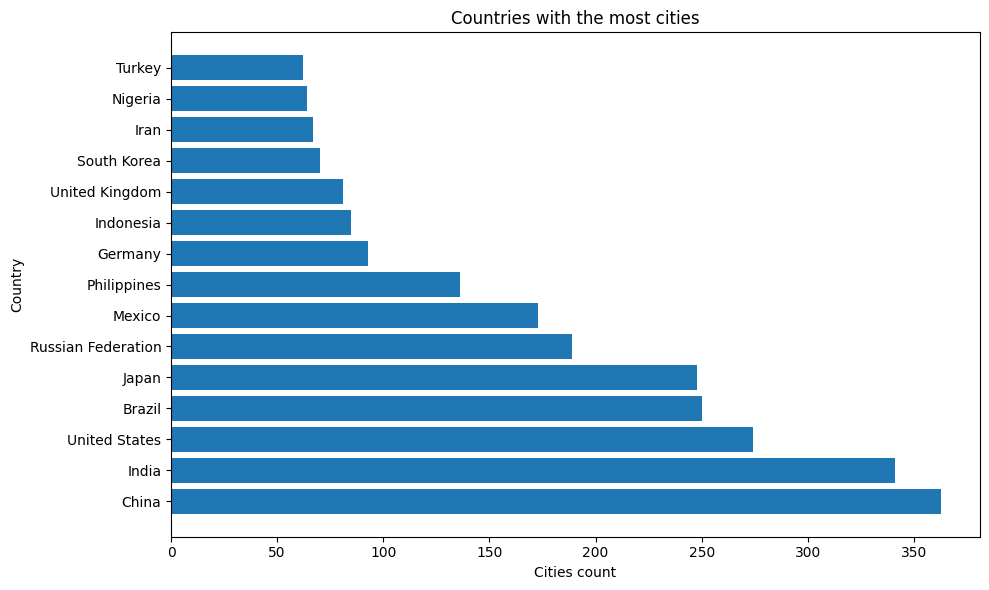

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

top15 = df_countries.head(15)
plt.barh(top15['country_name'], top15['city_count'])
plt.xlabel('Cities count')
plt.ylabel('Country')
plt.title('Countries with the most cities')
plt.tight_layout()
plt.show()


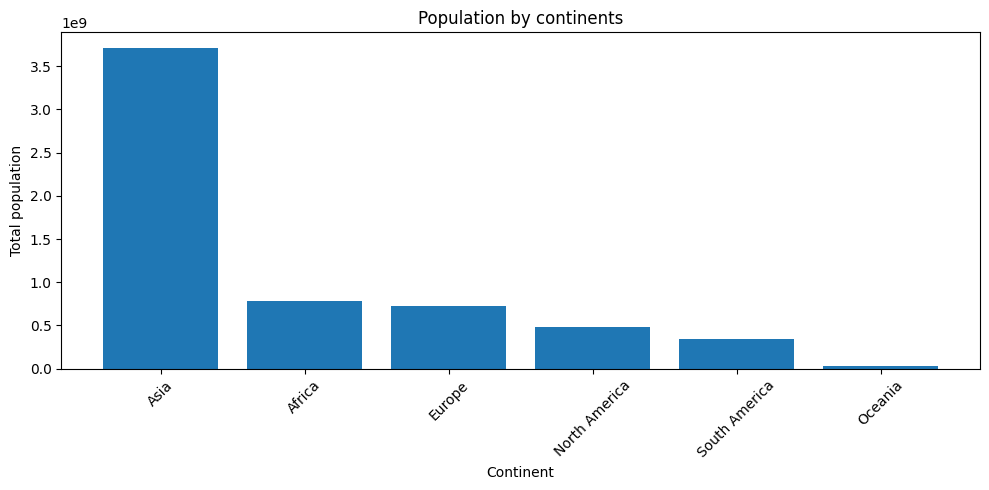

In [78]:
plt.figure(figsize=(10, 5))

plt.bar(df_continents['continent'], df_continents['total_population'])
plt.xlabel('Continent')
plt.ylabel('Total population')
plt.title('Population by continents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

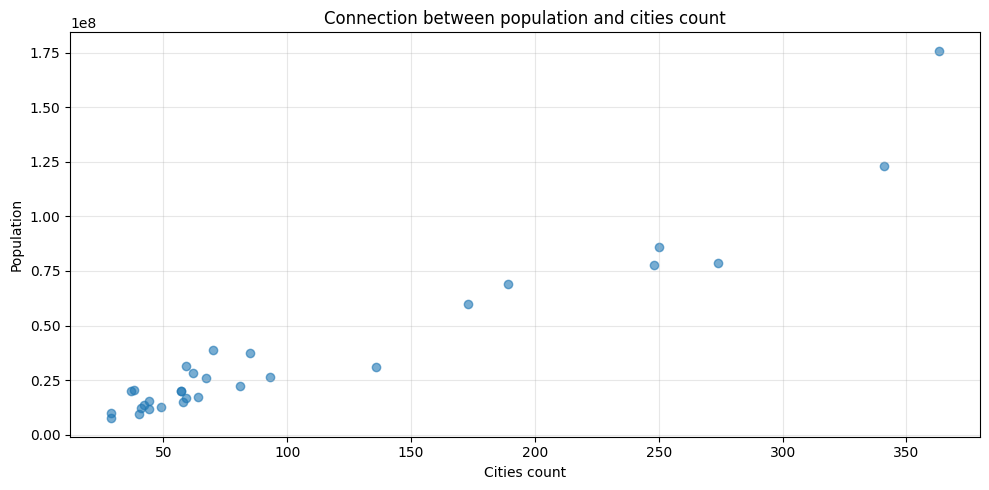

In [79]:
plt.figure(figsize=(10, 5))

plt.scatter(df_countries['city_count'], 
            df_countries['total_city_population'],
            alpha=0.6)
plt.xlabel('Cities count')
plt.ylabel('Population')
plt.title('Connection between population and cities count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Iceberg

In [80]:
schema_name = 'world_analytics'

try:
    cursor.execute(f"CREATE SCHEMA IF NOT EXISTS iceberg.{schema_name}")
    print(f"Created: {schema_name}")
except Exception as e:
    print(f"Error: {e}")

cursor.execute("SHOW SCHEMAS FROM iceberg")
schemas = cursor.fetchall()

print("\nIceberg schemas:")
for s in schemas:
    print(s[0])

Created: world_analytics

Iceberg schemas:
information_schema
system
world_analytics


In [81]:
table_name = 'country_stats'

try:
    cursor.execute(f"DROP TABLE IF EXISTS iceberg.{schema_name}.{table_name}")
    print("Removed old table if exists")
except:
    pass

create_sql = f"""
CREATE TABLE iceberg.{schema_name}.{table_name} (
    analysis_date DATE,
    country_name VARCHAR,
    continent VARCHAR,
    city_count BIGINT,
    total_population BIGINT,
    data_type VARCHAR,
    created_timestamp DATE
)
"""

try:
    cursor.execute(create_sql)
    print(f"Created: {table_name}")
except Exception as e:
    print(f"Error: {e}")

Removed old table if exists
Created: country_stats


In [82]:
cursor.execute(f"DESCRIBE iceberg.{schema_name}.{table_name}")
struct = cursor.fetchall()

print("Structure:")
for s in struct:
    print(f"{s[0]}: {s[1]}")

Structure:
analysis_date: date
country_name: varchar
continent: varchar
city_count: bigint
total_population: bigint
data_type: varchar
created_timestamp: date


In [83]:
# countries

from datetime import datetime

count = 0
for i, row in df_countries.iterrows():
    country_clean = row['country_name'].replace("'", "''")
    
    insert_sql = f"""
    INSERT INTO iceberg.{schema_name}.{table_name}
    VALUES (
        CURRENT_DATE,
        '{country_clean}',
        '{row['continent']}',
        {row['city_count']},
        {row['total_city_population']},
        'country_detail',
        TIMESTAMP '{datetime.now()}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by countries")

Inserted 30 rows by countries


In [84]:
# continents

count = 0
for i, row in df_continents.iterrows():
    insert_sql = f"""
    INSERT INTO iceberg.{schema_name}.{table_name}
    VALUES (
        CURRENT_DATE,
        'CONTINENT_TOTAL',
        '{row['continent']}',
        {row['country_count']},
        {row['total_population']},
        'continent_summary',
        TIMESTAMP '{datetime.now()}'
    )
    """
    cursor.execute(insert_sql)
    count += 1

print(f"Inserted {count} rows by continents")

Inserted 6 rows by continents


In [85]:
check_sql = f"""
SELECT 
    data_type,
    COUNT(*) as record_count,
    SUM(city_count) as total_cities,
    SUM(total_population) as total_pop
FROM iceberg.{schema_name}.{table_name}
GROUP BY data_type
"""

cursor.execute(check_sql)
res = cursor.fetchall()
df_check = pd.DataFrame(res, columns=['type', 'records', 'cities', 'population'])

print("Checking data:")
print(df_check)

Checking data:
                type  records  cities  population
0  continent_summary        6     232  6078749450
1     country_detail       30    3179  1133969680


In [87]:
check_last = f"""
SELECT *
FROM iceberg.{schema_name}.{table_name}
ORDER BY created_timestamp DESC
LIMIT 10
"""

cursor.execute(check_last)
res = cursor.fetchall()
cols = [d[0] for d in cursor.description]
df_last = pd.DataFrame(res, columns=cols)

print("\nLast rows:")
print(df_last)


Last rows:
  analysis_date     country_name      continent  city_count  total_population  \
0    2026-01-07            Spain         Europe          59          16669189   
1    2026-01-07           Turkey           Asia          62          28327028   
2    2026-01-07          Ukraine         Europe          57          20074000   
3    2026-01-07           France         Europe          40           9244494   
4    2026-01-07          Nigeria         Africa          64          17366900   
5    2026-01-07            China           Asia         363         175953614   
6    2026-01-07  CONTINENT_TOTAL  North America          37         482993000   
7    2026-01-07           Brazil  South America         250          85876862   
8    2026-01-07            Chile  South America          29           9717970   
9    2026-01-07           Poland         Europe          44          11687431   

           data_type created_timestamp  
0     country_detail        2026-01-07  
1     country_

In [88]:
check_continent = f"""
SELECT 
    continent,
    SUM(city_count) as cities,
    SUM(total_population) as population
FROM iceberg.{schema_name}.{table_name}
WHERE data_type = 'country_detail'
GROUP BY continent
ORDER BY population DESC
"""

cursor.execute(check_continent)
res = cursor.fetchall()
df_cont_check = pd.DataFrame(res, columns=['continent', 'cities', 'population'])

print("\nAggregation by continents from Iceberg:")
print(df_cont_check)


Aggregation by continents from Iceberg:
       continent  cities  population
0           Asia    1473   584113725
1         Europe     650   198063995
2  North America     496   151052135
3  South America     415   148093476
4         Africa     145    52646349
